# Aluminum Price Forecast using Time Series Analysis

## Background:

India has made huge strides in building renewable energy capacity and ranks fourth globally in terms of overall renewable energy capacity. As of May 2021, we have 95.6 gigawatts (GW) of installed renewable energy capacity, almost half of which (41 GW) is solar energy.In April 2021, the government approved the Production-Linked Incentive (PLI) scheme for the solar PV manufacturing sector, with INR 4500 crore (US$603 million) allocated by the Ministry of New and Renewable Energy (MNRE) for investment in high-efficiency solar PV modules.(Source: https://www.pv-magazine-india.com/2021/07/14/no-excuses-india-must-ramp-up-solar-manufacturing-to-reduce-reliance-on-imports/)



The PV Module manufacturing sector has seen a exponential growth in the recent years and thus to be more competitive in terms of module cost/Wp, they have focussed on increasing their Supply Chain Efficiency. The module manufacturing companies are highly dependent on foreign sources (mainly China) for the raw materials. Various raw materials like the Solar Cells, EVA, Backsheet, JBs and aluminium frames are imported from the foreign countries. The constant reliance on imports mean higher TATs in procurement and thus the companies have been investing on devising forecasting processes to gain an advantage in terms of cost and lead times.

## Business Case:

Due to the festive holidays in India in Novemeber and December and the Chinese New Year in middle January, manufacturing gets delayed and vessel spaces become a problem in Ocean Logistics and hence the TAT may go upto 90 days from the normal 60 days.

Hence the Solar Company conducting the study wishes to **Predict** the prices of Aluminum Ingot during the upcoming months. The Aluminum ingot is the principle component of Aluminum frames which forms a significant price of the overall PV Module. The company has an option to bulk purchase the aluminum ingots and ask their suppliers to do the fabrication and process staggered deliveries as per the Purchase Orders. So the company management wishes to check whether bulk purchase of Aluminum ingot would be a more cost efficient option or should they wait to procure at the market price.


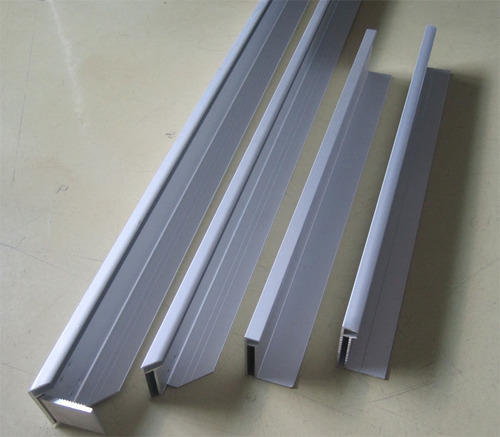

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline



from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
    

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [28]:
## Loading the data and Creating a DatetimeIndex

In [38]:
df = pd.read_csv("weekprice.csv", index_col="Date", parse_dates=True)
df["Price"]=df["Price"].apply(lambda x: x[0]+x[2:]).astype(float)
df = df.resample(rule="W").mean()
df.head(10)

,Price
Date,
2018-11-25,1958.0
2018-12-02,1955.0
2018-12-09,1926.0
2018-12-16,1909.0
2018-12-23,1845.0
2018-12-30,1865.0
2019-01-06,1836.0
2019-01-13,1870.0
2019-01-20,1920.0


<AxesSubplot:xlabel='Date'>

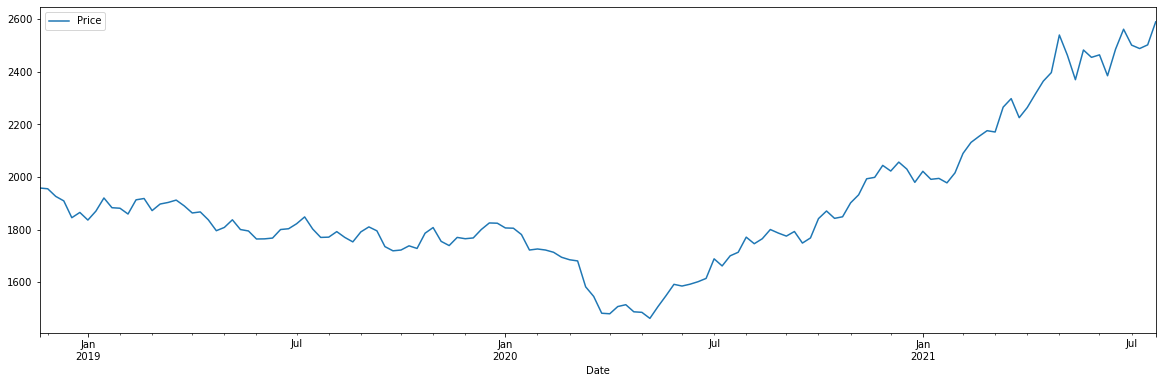

In [41]:
df.plot(figsize=(20,6))

## Performing ETS Decomposition on the dataset

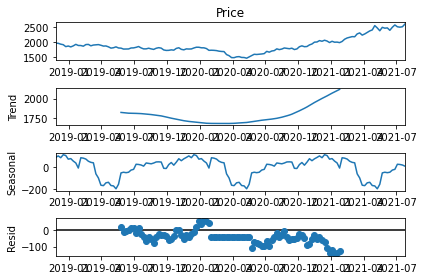

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Price'], model='additive')  # model='add' also works
result.plot();

## Conducting Adjusted Dickey-Fuller Test to check for Stationarity in the Data

In [43]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series): #defining a function to conduct the ADF Test
    
    print(f'Augmented Dickey-Fuller Test: ')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() drop sthe null rows obtained after differencing
    
    labels = ['ADF test statistic','p-value','No. of lags used','No. of observations']
    out = pd.Series(result[0:4],index=labels) #displays the output dictionary in easily interpretable form

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() is used to remove the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [44]:
adf_test(df["Price"])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.347047
p-value                   0.979403
No. of lags used          7.000000
No. of observations     132.000000
critical value (1%)      -3.480888
critical value (5%)      -2.883697
critical value (10%)     -2.578586
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Running an auto_arima to check the recommended orders.

In [8]:
from pmdarima import auto_arima 
auto_arima(df['Price'],seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  140
Model:             SARIMAX(1, 2, 3)x(1, 0, [1, 2], 12)   Log Likelihood                -697.744
Date:                                 Tue, 30 Aug 2022   AIC                           1411.488
Time:                                         23:38:57   BIC                           1434.906
Sample:                                              0   HQIC                          1421.004
                                                 - 140                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8102      0.061    -13.281      0.000      -0.930      -0.691
ma.L1         -0.1924      0.094     -2.047      0.041      -0.377      -0.008
ma.L2         -0.9233      0.045    -20.736      0.000      -1.011      -0.836
ma.L3          0.2017      0.081      2.480      0.013       0.042       0.361
ar.S.L12       0.7949      0.201      3.961      0.000       0.402       1.188
ma.S.L12      -0.9620      0.200     -4.821      0.000      -1.353      -0.571
ma.S.L24       0.3470      0.104      3.346      0.001       0.144       0.550
sigma2      1363.6622    167.455      8.143      0.000    1035.456    1691.868
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.97   Prob(JB):                         0.25
Heteroskedasticity (H):               2.94   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Dividing the data into train and test pairs

In [14]:
train = df.iloc[:120]
test = df.iloc[120:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
#creating the time-series Model.
model = SARIMAX(train['Price'],order=(1,2,3),seasonal_order=(1, 0, [1,2], 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Price   No. Observations:                  120
Model:             SARIMAX(1, 2, 3)x(1, 0, [1, 2], 12)   Log Likelihood                -574.992
Date:                                 Tue, 30 Aug 2022   AIC                           1165.984
Time:                                         23:40:15   BIC                           1188.150
Sample:                                     11-25-2018   HQIC                          1174.984
                                          - 03-07-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9206      0.076    -12.178      0.000      -1.069      -0.772
ma.L1          0.0581      0.134      0.435      0.664      -0.204       0.320
ma.L2         -0.9294      0.066    -14.028      0.000      -1.059      -0.800
ma.L3         -0.0150      0.110     -0.137      0.891      -0.230       0.200
ar.S.L12       0.5965      0.347      1.719      0.086      -0.084       1.277
ma.S.L12      -0.6615      0.342     -1.933      0.053      -1.332       0.009
ma.S.L24       0.2271      0.133      1.713      0.087      -0.033       0.487
sigma2       966.6877    153.505      6.297      0.000     665.823    1267.553
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.84   Prob(JB):                         0.42
Heteroskedasticity (H):               1.31   Skew:                            -0.24
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Obtaining the model predictions

In [17]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,2,3)(1,0,[1,2],12) Predictions')

In [49]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<6.5}, expected={test['Price'][i]}, variation = {(predictions[i] - test['Price'][i]):<5.4}")

predicted=2196.6, expected=2265.5, variation = -68.93
predicted=2228.2, expected=2298.0, variation = -69.8
predicted=2245.8, expected=2225.5, variation = 20.34
predicted=2262.6, expected=2264.0, variation = -1.381
predicted=2280.6, expected=2315.0, variation = -34.41
predicted=2307.4, expected=2364.5, variation = -57.08
predicted=2326.6, expected=2397.0, variation = -70.37
predicted=2356.9, expected=2540.0, variation = -183.1
predicted=2364.7, expected=2463.0, variation = -98.33
predicted=2386.7, expected=2370.0, variation = 16.65
predicted=2396.5, expected=2483.0, variation = -86.47
predicted=2414.0, expected=2455.0, variation = -41.02
predicted=2426.2, expected=2464.5, variation = -38.3
predicted=2439.8, expected=2385.0, variation = 54.84
predicted=2465.4, expected=2486.0, variation = -20.59
predicted=2471.3, expected=2562.0, variation = -90.66
predicted=2487.2, expected=2501.5, variation = -14.27
predicted=2504.0, expected=2488.5, variation = 15.54
predicted=2528.3, expected=2502.5,

## Plotting the predictions against Test Set

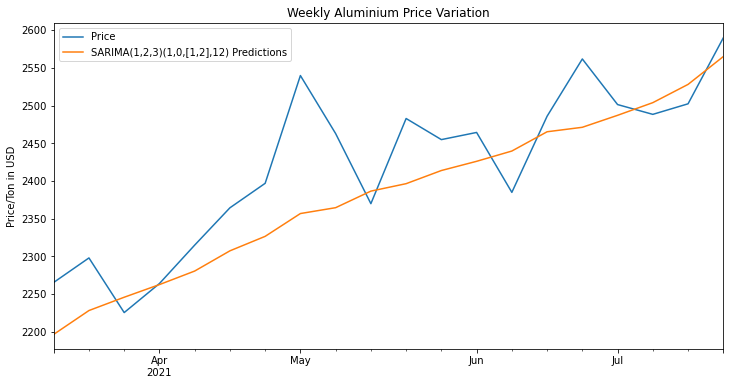

In [19]:
# Plot predictions against known values
title = 'Weekly Aluminium Price Variation'
ylabel='Price/Ton in USD'
xlabel=''

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Model Evaluation

In [51]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'SARIMA(0,2,1)(2,0,[1,2],12) MSE Error: {error:7.6}')

SARIMA(0,2,1)(2,0,[1,2],12) MSE Error: 4345.35


In [50]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['Price'], predictions)
print(f'SARIMA(0,2,1)(2,0,[1,2],12) RMSE Error: {error:7.6}')

SARIMA(0,2,1)(2,0,[1,2],12) RMSE Error: 65.9193


### The obtained RMSE is very good when compared to the individual data points.

## Let's train the model on the full dataset

In [53]:
model = SARIMAX(df['Price'],order=(0,2,1),seasonal_order=(2,0,[1,2],12))
results = model.fit()


## Forecasting the future

In [54]:
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,2,1)(2,0,[1,2],12) Forecast')

## Visualising the forecast

2021-08-01    2628.33
2021-08-08    2670.10
2021-08-15    2671.00
2021-08-22    2691.71
2021-08-29    2723.05
2021-09-05    2765.02
2021-09-12    2786.90
2021-09-19    2778.66
2021-09-26    2808.90
2021-10-03    2843.42
2021-10-10    2880.54
2021-10-17    2944.26
Freq: W-SUN, Name: SARIMA(0,2,1)(2,0,[1,2],12) Forecast, dtype: float64


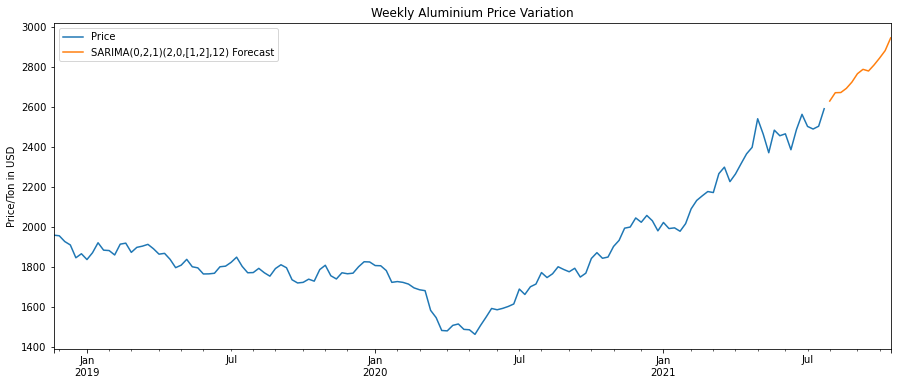

In [57]:
# Plot predictions against known values
title = 'Weekly Aluminium Price Variation'
ylabel='Price/Ton in USD'
xlabel=''


ax = df['Price'].plot(legend=True,figsize=(15,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

print(round(fcast,2))

## Recommendations for the Company

The following recommendations can be given to the company from our study.
- The price is going to see an increase in the next 3 months.
- The company may look forward to bulk purchase Aluminum Ingot provided it can ensure staggered delivery from its suppliers.